# Round III: Cutting Edge Model

> Random Forest for with price OHLC and many features

<div class="alert alert-block alert-info">
Insert story about how we take inspiration from the baseline to build this model. 
</div>

## An Introduction to the Forecasting library

Our codebase is structured in two halves: `src/classes.py`, which has our Forecasting class and `scr/lib.py`, which has helper functions. 

There are a few reasons why we have our code in this way than copying them over full: 

    1. Codebase is compact. 
    2. Any changes made are reverberated across the entire pipeline. 
    3. API calls are simple. 
    4. Complex functionality with single lines of code. 

Here, we will introduce the library, while demonstrating our model. 

## Setup

To use the library, you need to load the data beforehand so you can pass it to it, among other steps. Before you start an API call with the library, do the following, 

In [1]:
# To reload libraries after we make changes to them in real time without restarting the Kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Add path to the location of our library. 
import sys
sys.path.append('../src/')
import lib

Import some basic libraries, 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Set a random seed for reproducibility. 

In [4]:
np.random.seed(42)

### Load Data

Add the path where you keep your data files, 

In [5]:
data_path = '../data/'

For the model, I will load price OHLC data where the volume is summed. 

In [32]:
resampled_df = pd.read_pickle(data_path+'hourly_resampled_contracts_ohlcsv_weather.pkl')
resampled_df

contractId   qty                                       \
                    contractId  open  high   low close     sum        var   
2020-03-01 11:00:00   11629792   0.5   3.0   0.1   0.2     7.3   1.933667   
2020-03-01 11:00:00   11629866   6.0   6.0   1.0   5.0    28.0   3.466667   
2020-03-01 12:00:00   11629866   0.5  30.0   0.1   2.4  1755.3  11.694814   
2020-03-01 11:00:00   11629920   1.0   6.0   0.2   0.2    20.7   6.846190   
2020-03-01 12:00:00   11629920   1.0  20.0   0.1   3.0  1005.3  11.378282   
...                        ...   ...   ...   ...   ...     ...        ...   
2020-08-25 07:00:00   11877196   1.0  25.0   0.1   1.6  2240.2   8.645283   
2020-08-24 19:00:00   11879762   4.5   4.5   4.5   4.5     4.5  -1.000000   
2020-08-24 20:00:00   11879762  10.5  10.5  10.5  10.5    10.5  -1.000000   
2020-08-24 19:00:00   11879763  11.0  11.0  11.0  11.0    11.0  -1.000000   
2020-08-24 20:00:00   11879813  52.5  52.5  52.5  52.5    52.5  -1.000000   

                        px                                      hour  \
                      open   high    low  close        var             
2020-03-01 11:00:00  -0.99  -0.99  -1.00  -1.00   0.000027  0.000000   
2020-03-01 11:00:00   1.30   1.71   1.30   1.41   0.022627  0.000000   
2020-03-01 12:00:00   1.71  18.00  -5.57  -5.57  38.008268  0.035714   
2020-03-01 11:00:00  18.50  18.50  18.50  18.50   0.000000  0.000000   
2020-03-01 12:00:00  18.11  19.00  16.21  17.20   0.468105  0.035714   
...                    ...    ...    ...    ...        ...       ...   
2020-08-25 07:00:00  35.00  50.55   5.00  38.53   6.497054  0.571429   
2020-08-24 19:00:00  38.95  38.95  38.95  38.95  -1.000000  0.000000   
2020-08-24 20:00:00  38.95  38.95  38.95  38.95  -1.000000  0.035714   
2020-08-24 19:00:00  34.95  34.95  34.95  34.95  -1.000000  0.000000   
2020-08-24 20:00:00  37.98  37.98  37.98  37.98  -1.000000  0.000000   

                     air_temp rel_humidity wind_speed  wind_dir  \
                                                                  
2020-03-01 11:00:00  0.246006     0.646465   0.619048  0.583333   
2020-03-01 11:00:00  0.246006     0.646465   0.619048  0.583333   
2020-03-01 12:00:00  0.255591     0.636364   0.619048  0.527778   
2020-03-01 11:00:00  0.246006     0.646465   0.619048  0.583333   
2020-03-01 12:00:00  0.255591     0.636364   0.619048  0.527778   
...                       ...          ...        ...       ...   
2020-08-25 07:00:00  0.437700     0.969697   0.142857  0.194444   
2020-08-24 19:00:00  0.472843     0.929293   0.238095  0.166667   
2020-08-24 20:00:00  0.476038     0.939394   0.238095  0.194444   
2020-08-24 19:00:00  0.472843     0.929293   0.238095  0.166667   
2020-08-24 20:00:00  0.476038     0.939394   0.238095  0.194444   

                    n_prev_hour_contracts  
                                           
2020-03-01 11:00:00              0.146341  
2020-03-01 11:00:00              0.146341  
2020-03-01 12:00:00              0.146341  
2020-03-01 11:00:00              0.146341  
2020-03-01 12:00:00              0.146341  
...                                   ...  
2020-08-25 07:00:00              0.341463  
2020-08-24 19:00:00              0.634146  
2020-08-24 20:00:00              0.658537  
2020-08-24 19:00:00              0.634146  
2020-08-24 20:00:00              0.658537  

[63451 rows x 18 columns]

That's all for now! 

## Basic API calls

One of the easiest thing to try with the library is to forecast a Random Forest model with default hyperparameters. To begin, first import the library, 

In [33]:
from classes import Forecasting

### Step 1.1: Rolling Windows

The class first calculates rolling windows based on the `WINDOW_SIZE` and adds `features` to the data based on the list provided. The name of the available features can be found in the `lib.create_features()` function. The `ohlc` flag specifies if your data has ohlc values, as compared to data having only close prices (c.f. *data/hourly_resampled_contracts.pkl*). 

<div class="alert alert-block alert-danger">
<b>On feature selection:</b> Only select those features that can be calculated using the dataframe you provide above. Features like 'act_px_open' cannot be calculated as we don't have actual prices in the data we have loaded above. Also, order matters! Give the name of the functions in the same order as they appear in the function. 
</div>

To reduce computation time, we have provided a `recalculate` flag. Suppose you have already calculated rolling windows for a set of features. Since the calculation is computationally expensive, setting the flag to *False* means that it will try to load the previously computed windows, based on the `ohlc` flag and `WINDOW_SIZE`. If you set the `recalculate` flag to False and it cannot find your file based on your params, it will recompute automatically. However, the file name cannot tell you which features it has. It is on you to make sure the pkl file you want to load has the features you want to use for your analysis. **Whenever in doubt, just recalculate.**

In [34]:
WINDOW_SIZE = 5
features = ['t', 'weekday_sin', 'weekday_cos', 'run_hour', 
            'n_prev_hour_contracts', 'hour_sin', 'hour_cos', 
            'air_temp', 'rel_humidity', 'wind_speed', 'wind_dir',
            'holidays', 'qty_open', 'qty_high', 'qty_low', 'qty_close',
            'qty_var' ,'qty_sum', 'px_open','px_high', 'px_low', 'px_var']
ohlc = True
recalculate = False
save_to_pickle = False

### Step 1.2: Data Split

Based on the rolling windows generated above, we now compute a Train-Valid-Test split. The `test_set` flag controls if you want a test set. If False, we only have a Train-Valid split. You might not want a test set in cases where you don't have cross-validation. The first split percentage creates a Train-Test from rolling windows and the second carves out another Train-Test from the Test set of first split. 

In [35]:
test_set = False
split_pct_1 = 0.1
split_pct_2 = None

### Step 1.3 Model Selection

Finally, you specify the `regressor` you want to use. The exact naming convention for a specific regressor is in the docstring of the class. `params` accepts a dictionary of model parameters and the `grid_search` is a flag to use `GridSearchCV`. Presently, we support only Scikit-Learn regressors for grid search. If `grid_search` is True, `params` is expected to be a dictionary of parameters to do grid search on (as should be obvious). 

The model is automatically initialised and fitted. A set of regression metrics are calculated and made available. There is also an option to plot feature-importance for some regressors. 

In [36]:
regressor = 'randFor' 
params = {'max_features':'log2', 'n_estimators':110}
grid_search = False 

### Step 1.4: Call the API

Now that we have our paramters set up, we can make the API call to the Forecasting class. 

In [37]:
x = Forecasting(resampled_df, window_size=WINDOW_SIZE, features=features, ohlc=ohlc, 
                recalculate=recalculate, test_set=test_set, split_pct_1=split_pct_1,
                split_pct_2=split_pct_2, regressor=regressor, params=params, 
                grid_search=grid_search, save_to_pickle=save_to_pickle)

Fitting model...


In [38]:
x.metrics

,value
MSE,29.115072
RMSE,5.395838
MAE,2.637505
R2,0.883393


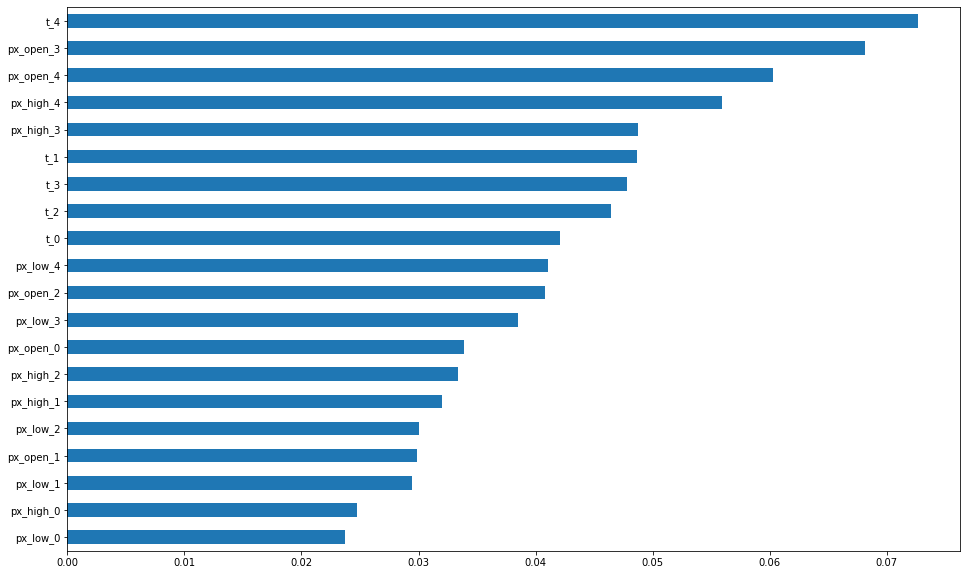

In [43]:
x.feature_importance('high')

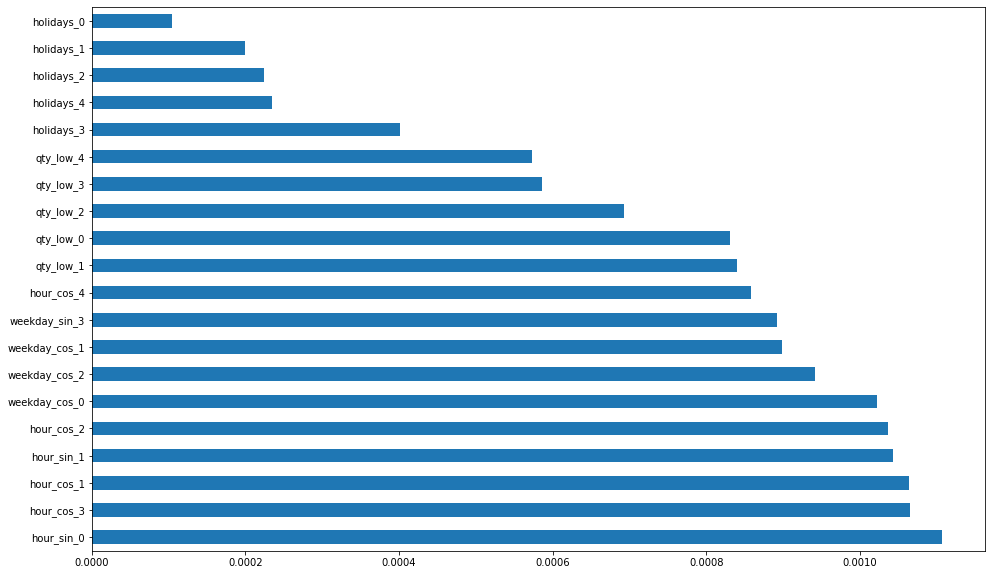

In [44]:
x.feature_importance('low')

<div class="alert alert-block alert-info">
The most important feature seems to be the closing price, with importance decreasing as you go back in time. We are suprised that the weekday and hour are among the least important features to the model when EDA suggested otherwise. There were very few holidays in the dataset, explaining why they have the lowest feature importance. 
</div>

<div class="alert alert-block alert-success">
With this very simple regression model, our MSE and MAE are already looking pretty good! From the R2, the model is a good fit to the data. 
</div>

## Analyse Errors

In [17]:
fig = px.histogram(x.y_valid-x.y_pred)
fig.update_xaxes(dtick=5)
fig.update_layout(title='Forecast Error')
fig.show()

The error is normally distributed with a peak exactly centered 0, but we have long tails. As for the quality of performance, there is no difference between over and under-predicting the price: both are equally bad. Because of this, we look at the absolute error. 

In [19]:
err = np.abs(x.y_valid-x.y_pred.reshape(-1,))

In [20]:
fig = px.histogram(err)
fig.update_layout(title='Forecast MAE Distribution')
fig.update_xaxes(tick0=0, dtick=5)
fig.show()

Few outliers are heavily off. A better measure for the accuracy of the model would be the Median Absolute Error. Being neutral to outliers, it is much better than our Mean Absolute Error. The extreme predictions are $\sim 1\%$ of the error distribution. 

In [51]:
from sklearn.metrics import median_absolute_error
median_absolute_error(x.y_valid, x.y_pred)

1.2788181818181776

For comparison, 

In [53]:
x.metrics.loc['MAE']

value    2.637505
Name: MAE, dtype: float64

In [56]:
1 - len(err[err>25])/len(err)

0.9894500561167228

But are the outliers really that extreme? Couldn't it be that an outlier that these extreme outliers trading at high closing prices? 

In [57]:
np.max(x.y_valid)

124.15

In [63]:
fig = px.histogram(x.y_pred/x.y_valid - 1)
fig.update_layout(title='Percent Error Distribution')
fig.update_xaxes(tick0=0, dtick=10)
fig.show()

/Users/dipanshugupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



In [64]:
perct_err = x.y_pred/x.y_valid - 1
len(perct_err[np.abs(perct_err)<10])/len(perct_err)

/Users/dipanshugupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



0.9943883277216611

Our percentage deviation is even more centred than the absolute error, suggesting based on the price of the contract, on average, our forecast was good. When considering percentage, there are even fewer outliers. This suggests that the extreme outliers in the absolute error case above are directly related to very high closing prices and not as bad when accounting for the actual price level.

### Jumps

In [58]:
X_valid = x.X_valid
X_valid['err'] = np.abs(x.y_valid-x.y_pred.reshape(-1,))
X_valid['t_y'] = x.y_valid
cols = [f't_{i}' for i in range(WINDOW_SIZE)] + ['t_y', 'err']

In [59]:
big_errs = X_valid[X_valid['err']>50][cols]
big_errs

,t_0,t_1,t_2,t_3,t_4,t_y,err
31244,18.35,18.35,118.47,44.17,7.49,119.37,73.336182
32995,80.01,133.00,105.10,30.22,55.67,124.15,68.147000
9317,30.71,30.93,32.34,36.51,49.90,86.44,51.347000
28066,-25.80,-25.80,-4.99,-25.80,-20.80,-70.00,50.882182
38068,45.77,42.91,42.95,41.70,40.96,100.00,58.568545


In [46]:
fig = go.Figure()
for i in big_errs.index:
    trace = go.Scatter(x=np.arange(6), y=big_errs.loc[i], name=i)
    fig.add_trace(trace)
fig.update_xaxes(dtick=1)
fig.update_layout(title='Largest Errors')
fig.show()

<div class="alert alert-block alert-info">
The rolling windows we had the largest errors had a sudden jump in the closing price (the ground truth). It is, in usual, hard to forecast these jumps. It was expected that the features we collected, especially the auxillary weather data could add meaningful information about why there was a sudden jump, but unfotunately this was not the case. Further inspection of the features of the shown rolling windows did not yield any meaningful insight as well.
</div>

### Variance

Let us see the rows where our model performed bad. We add the prediction an error to a dataframe to create `df_err`. 

In [20]:
df_err = x.forecast_df.copy()
df_err = df_err.loc[x.X_valid.index]
df_err['pred'] = x.y_pred
df_err['err'] = err

Only interested in some columns

In [21]:
px_cols = [f't_{i}' for i in range(WINDOW_SIZE)] 
cols = ['contractId'] + px_cols + ['t_y', 'pred', 'err']

Errors greater than threshold, 

In [22]:
df_err[cols][df_err['err']>16]

,contractId,t_0,t_1,t_2,t_3,t_4,t_y,pred,err
28468,11837414,0.99,0.00,-0.70,46.00,36.00,3.49,30.5918,27.1018
14774,11661228,30.03,32.94,31.16,34.51,44.89,70.68,35.8081,34.8719
28316,11757114,-29.13,-32.50,-40.10,-44.01,-44.41,0.00,-45.3635,45.3635
31272,11659390,-18.00,-18.00,-25.00,-15.10,-17.00,-45.00,-18.8091,26.1909
28471,11837414,46.00,36.00,3.49,45.50,3.51,2.62,27.6126,24.9926
...,...,...,...,...,...,...,...,...,...
23981,11805128,-40.22,-55.89,10.15,-10.00,8.15,-65.90,-22.4532,43.4468
33213,11798075,3.70,2.50,7.25,1.71,2.16,0.51,26.9978,26.4878
25220,11806480,27.89,30.17,1.99,26.79,31.39,-1.00,25.9860,26.9860
38238,11823580,22.89,21.99,21.30,21.60,24.54,4.50,23.2852,18.7852


Just by eyeballing, it is clear to see that in scenarios our model performs bad, it is because of very sharp price jumps. It is very difficult to forecast them. Let us check the standard deviation of these rows, 

In [23]:
std_bad = df_err[px_cols+['t_y']][df_err['err']>16].std(axis=1)
std_bad

28468    20.972754
14774    15.618903
28316    16.707930
31272    11.281918
28471    21.817266
           ...    
23981    32.911401
33213     2.339551
25220    14.870094
38238     7.426148
27038    19.415456
Length: 131, dtype: float64

In [24]:
fig = px.histogram(std_bad)
fig.update_layout(title='Standard Deviation of bad predictions')
fig.update_xaxes(tick0=0, dtick=5)
fig.show()

Comparing this to the standard deviation of good predictions, 

In [25]:
std_good = df_err[px_cols+['t_y']][df_err['err']<=16].std(axis=1)
std_good

34509     9.348886
37712     2.128293
21228     0.988528
35830     7.872234
37933     2.971615
           ...    
22114     5.228193
20940    12.469500
38849     3.744633
6687     13.046459
40815     0.747306
Length: 4324, dtype: float64

In [26]:
fig = px.histogram(std_good)
fig.update_layout(title='Standard Deviation of good predictions')
fig.update_xaxes(tick0=0, dtick=5)
fig.show()

Very few of the good forecasts have a standard deviation greater than 5. In general, our model will perform worse with such data points. 

# Appendix

## Determining the best WINDOW_SIZE

One can run a for loop to determine the best rolling window for the task. There is usually a tradeoff here: if you have shorter rolling windows, you will have less price information to forecast ahead. If you have a larger rolling window, you will have less data to train your model on because you will drop more time series because we drop contracts with length less than $(\text{WINDOW_SIZE}+1)$. 

In [27]:
x_ = {}
for w in [3,4,5,6,7,8,9,10]:
    print(w)
    x_[w] = Forecasting(resampled_df, window_size=w, features=features, ohlc=ohlc, 
                recalculate=recalculate, test_set=test_set, split_pct_1=split_pct_1,
                split_pct_2=split_pct_2, regressor=regressor, params=params, 
                grid_search=grid_search, save_to_pickle=save_to_pickle)

3
Calculating rolling windows...
Fitting model...
4
Calculating rolling windows...
Fitting model...
5
Calculating rolling windows...
Fitting model...
6
Calculating rolling windows...
Fitting model...
7
Calculating rolling windows...
Fitting model...
8
Calculating rolling windows...
Fitting model...
9
Calculating rolling windows...
Fitting model...
10
Calculating rolling windows...
Fitting model...


In [28]:
results = pd.DataFrame(index=x_[3].metrics.index)
for i in x_.keys():
    results[i] = x_[i].metrics.values

In [29]:
results

,3,4,5,6,7,8,9,10
MSE,43.078070,37.901171,40.034981,41.045787,39.654959,38.902389,43.609323,34.176025
RMSE,6.563389,6.156393,6.327320,6.406699,6.297218,6.237178,6.603736,5.846026
MAE,3.208630,2.955137,2.938254,2.857711,2.851681,2.848650,3.001871,2.839712
R2,0.833859,0.861271,0.854568,0.848451,0.866616,0.864386,0.833927,0.855640


In [30]:
results.iloc[:-1].min(axis=1)

MSE     34.176025
RMSE     5.846026
MAE      2.839712
dtype: float64

In [31]:
results.loc['R2'].max()

0.8666155727746607